In [ ]:
!pip install conllu

In [ ]:
import pandas as pd
from conllu import parse

def conll2003_to_csv(conll_file_path):
    with open(conll_file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    data = {'Word': [], 'Tag': []}

    for line in lines:
        line = line.strip()
        if line and not line.startswith('-DOCSTART-'):
            parts = line.split()
            if len(parts) == 4:
                word = parts[0]
                tag = parts[3]
                data['Word'].append(word)
                data['Tag'].append(tag)

    df = pd.DataFrame(data)
    return df

In [ ]:
def conll2003_to_csv_2(conll_file_path):
    with open(conll_file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    data = {'Word': [], 'Tag': []}

    for line in lines:
        line = line.strip()
        if line and not line.startswith('-DOCSTART-'):
            parts = line.split()
            if len(parts) == 2:
                word = parts[0]
                tag = parts[1]
                data['Word'].append(word)
                data['Tag'].append(tag)

    df = pd.DataFrame(data)
    return df

In [ ]:
train = conll2003_to_csv("/content/NER_Irish_train.conll")
val = conll2003_to_csv_2("/content/NER_Irish_validation.conll")
test = conll2003_to_csv_2("/content/NER_Irish_test.conll")

In [ ]:
print(train.head(10))

       Word    Tag
0     ﻿Dáil  B-ORG
1   Éireann  I-ORG
2        06      O
3         /      O
4        07      O
5         /      O
6      2023      O
7  Baineann      O
8        mo      O
9    cheist      O


In [ ]:
print(test.head(10))

        Word    Tag
0        Mar      O
1          a      O
2   tchítear      O
3         do      O
4   Sheosamh  B-PER
5        Mac  I-PER
6    Grianna  I-PER
7          é      O
8  caithfidh      O
9         an      O


In [ ]:
print(val.head(10))

         Word    Tag
0  Crothnófar      O
1         Pól  B-PER
2          nó      O
3          ba      O
4   úrlabhraí      O
5       maith      O
6           é      O
7          ar      O
8      Raidió  B-ORG
9          na  I-ORG


In [ ]:
def tag_count(df):
    tag_counts = df['Tag'].value_counts().to_dict()
    tag_counts = dict(sorted(tag_counts.items()))
    return tag_counts

In [ ]:
train_tags = tag_count(train)
print(train_tags)
val_tags = tag_count(val)
print(val_tags)
test_tags = tag_count(test)
print(test_tags)

{'B-LOC': 677, 'B-ORG': 827, 'B-PER': 579, 'I-LOC': 757, 'I-ORG': 1439, 'I-PER': 639, 'O': 24868}
{'B-LOC': 61, 'B-ORG': 75, 'B-PER': 65, 'I-LOC': 38, 'I-ORG': 102, 'I-PER': 85, 'O': 2507}
{'B-LOC': 129, 'B-ORG': 97, 'B-PER': 109, 'I-LOC': 138, 'I-ORG': 136, 'I-PER': 115, 'O': 3388}


In [ ]:
def merge_B_I_tags(tag_counts):
    merged_counts = {}

    for tag in tag_counts:
        if tag.startswith(('B-', 'I-')):
            base_tag = tag[2:]  # Remove 'B-' or 'I-' prefix
            if base_tag not in merged_counts:
                merged_counts[base_tag] = tag_counts[tag]
            else:
                merged_counts[base_tag] += tag_counts[tag]

    return merged_counts

In [ ]:
merged_train = merge_B_I_tags(train_tags)
merged_train['O'] = train_tags['O']
print(merged_train)

merged_val = merge_B_I_tags(val_tags)
merged_val['O'] = val_tags['O']
print(merged_val)

merged_test = merge_B_I_tags(test_tags)
merged_test['O'] = test_tags['O']
print(merged_test)

{'LOC': 1434, 'ORG': 2266, 'PER': 1218, 'O': 24868}
{'LOC': 99, 'ORG': 177, 'PER': 150, 'O': 2507}
{'LOC': 267, 'ORG': 233, 'PER': 224, 'O': 3388}


In [ ]:
counts = pd.DataFrame()
counts['Tag'] = merged_train.keys()

counts['Train'] = counts['Tag'].map(merged_train)
counts['Validation'] = counts['Tag'].map(merged_val)
counts['Test'] = counts['Tag'].map(merged_test)

In [ ]:
counts

,Tag,Train,Validation,Test
0,LOC,1434,99,267
1,ORG,2266,177,233
2,PER,1218,150,224
3,O,24868,2507,3388


In [ ]:
counts = counts.reset_index(drop=True)
counts

,Tag,Train,Validation,Test
0,LOC,1434,99,267
1,ORG,2266,177,233
2,PER,1218,150,224
3,O,24868,2507,3388


In [ ]:
transposed_df = counts.pivot_table(index='Tag', values=['Train', 'Validation', 'Test'], aggfunc='sum')

transposed_df

,Test,Train,Validation
Tag,,,
LOC,267,1434,99
O,3388,24868,2507
ORG,233,2266,177
PER,224,1218,150


In [ ]:
reordered_df = pd.concat([transposed_df.drop(index='O'), transposed_df.loc[['O']]])

print(reordered_df)

     Test  Train  Validation
Tag                         
LOC   267   1434          99
ORG   233   2266         177
PER   224   1218         150
O    3388  24868        2507


In [ ]:
reordered_df = reordered_df[['Train', 'Validation', 'Test']]

print(reordered_df)

     Train  Validation  Test
Tag                         
LOC   1434          99   267
ORG   2266         177   233
PER   1218         150   224
O    24868        2507  3388


In [ ]:
column_totals = reordered_df.sum()
reordered_df = pd.concat([reordered_df, column_totals.to_frame().T])

# Calculate row-wise totals
row_totals = reordered_df.sum(axis=1)
row_totals.name = 'Total'

# Append row-wise totals as a new column
reordered_df['Total'] = row_totals

print(reordered_df)

     Train  Validation  Test  Total
LOC   1434          99   267   1800
ORG   2266         177   233   2676
PER   1218         150   224   1592
O    24868        2507  3388  30763
0    29786        2933  4112  36831


In [ ]:
reordered_df.to_csv('tag_counts.csv')

In [ ]:
def extract_joined_words(df):
    joined_words = []
    current_word = ""
    current_tag = ""

    for index, row in df.iterrows():
        word = row['Word']
        tag = row['Tag']

        if tag.startswith('B-'):
            if current_word != "":
                joined_words.append(current_word)
            current_word = word
            current_tag = tag[2:]  # Remove 'B-'
        elif tag.startswith('I-'):
            if current_tag == tag[2:]:
                current_word += " " + word
            else:
                joined_words.append(current_word)
                current_word = word
                current_tag = tag[2:]  # Remove 'I-'
        else:
            if current_word != "":
                joined_words.append(current_word)
            current_word = ""
            current_tag = ""

    if current_word != "":
        joined_words.append(current_word)

    return joined_words

In [ ]:
train_words = extract_joined_words(train)
val_words = extract_joined_words(val)
test_words = extract_joined_words(test)

In [ ]:
print(train_words)
print(len(train_words))

['\ufeffDáil Éireann', 'nGaillimh', 'nGaillimh', 'Dé', 'Dail Éireann', 'Andrews', 'Aire Stáit', 'Dáil', 'Fís Éireann', 'RTÉ', 'TG4', 'Údarás Craolacháin na hÉireann', 'Leas-Cheann Comhairle', 'Leas-Cheann Comhairle', 'RTÉ', 'RTÉ', 'RTÉ', 'Nike', 'Jennifer Lawrence', 'an Stáit', 'Palaistíne', 'mBruach Thiar', 'Iosrael', 'Taoiseach', 'Iordáin', 'RTÉ', 'RTÉ', 'Sky', 'RTÉ', 'Baile Átha Cliath', 'Dála', 'Sinn Féin', 'Dála', 'gCluain Leathard', 'Aire', 'Éamon Ó Cuív', 'Aire Oideachais', 'Ó Cuív', 'Ghaeltacht', 'An Garda Síochána', 'Éamon Ó Cuív', 'gCeathrú Rua', 'Ó Cuív', 'Cheathrú Rua', 'Gaeltachta', 'Ghaeltacht dheisceart', 'Chonamara', 'Ghaeltacht Conamara', 'Áras Mhic Dara', 'Áras Mhic Dara', 'HSE', 'Chonamara', 'Ceathrún Rua', 'HSE', 'Ceathrún Rua', 'dheisceart Chonamara', 'HSE', 'gCeathrú Rua', 'Aire Stáit', 'HSE', 'Raidió na Gaeltachta', 'TG4', 'gConamara', 'Ghaeltacht', 'Aire Stáit', 'Donnelly', 'Aire', 'gCeathrú Rua', 'gCo na Gaillimhe', 'Áras Mhic Dara', 'Ó Cuív', 'Butler', '', 'Sl

In [ ]:
import numpy as np

unique = {'Validation':[],
          'Test':[]}

for words in val_words:
  if words not in train_words:
    unique['Validation'].append(words)

for words in test_words:
  if words not in train_words:
    unique['Test'].append(words)

print('Validation:')
print(unique['Validation'])
print(f'Not in training: {len(unique["Validation"])}, Unique Entities not in training: {len(np.unique(unique["Validation"]))}, Total Entities: {len(val_words)}')
print(f'\nTest:')
print(unique["Test"])
print(f'Not in training: {len(unique["Test"])}, Unique Entities not in training: {len(np.unique(unique["Test"]))}, Total Entities: {len(test_words)}')

Validation:
['Concepta', 'Eoin Mac Diarmada', 'mBaile na dTor', 'Robert de Niro', 'Kenneth Branagh', 'Tom Hulce', 'Helena Bonham-Carter', 'John Cleese', 'Ian Holm', 'Robert Hardy', 'Corrán Binne', 'Barcó', 'Plunket Greene', 'George Mackay Brown', 'bhFine Gael', 'Cumann Fíoncheannaithe Bhaile Átha Cliath', 'gCúirt Chéadchéime', 'Cláraitheoir na Cúirte Breithiúnais', 'Cláraitheoir na Cúirte Céadchéime', 'Cláraitheoir na Cúirte Céadchéime', 'Cláraitheoir na Cúirte Breithiúnais', 'Cnocán an Ultaigh', 'Ultach', 'Sheán Sheáin Í Chearnaigh', 'Dublin and Banagher Distillery', 'Sheán Ó Gallchóir', 'Stiúrthóir Ginearálta an Fhorais Riaracháin', 'Seosaimhín Ní Bheaglaoich', 'mBaile na bPoc', 'Contae Chiarraí', 'Sherwood Foresters', 'Shráid an Mhóta', 'Dhún Laoghaoire', 'Micheal D. Higgins', 'Colm Cille', 'Cholm Cille', 'Michael Mullen', 'Lecanvey', 'Pádraic Ua Dubhthaigh', 'AIE', 'gCearnóg Pheadair', 'Longueville', 'Co. Chorcaí', 'Dick Spring', "Shiobhán O ' Keefe", 'gCeann Trá', 'Hollywood', 'gC

In [ ]:
print(unique)

{'Validation': ['Concepta', 'Eoin Mac Diarmada', 'mBaile na dTor', 'Robert de Niro', 'Kenneth Branagh', 'Tom Hulce', 'Helena Bonham-Carter', 'John Cleese', 'Ian Holm', 'Robert Hardy', 'Corrán Binne', 'Barcó', 'Plunket Greene', 'George Mackay Brown', 'bhFine Gael', 'Cumann Fíoncheannaithe Bhaile Átha Cliath', 'gCúirt Chéadchéime', 'Cláraitheoir na Cúirte Breithiúnais', 'Cláraitheoir na Cúirte Céadchéime', 'Cláraitheoir na Cúirte Céadchéime', 'Cláraitheoir na Cúirte Breithiúnais', 'Cnocán an Ultaigh', 'Ultach', 'Sheán Sheáin Í Chearnaigh', 'Dublin and Banagher Distillery', 'Sheán Ó Gallchóir', 'Stiúrthóir Ginearálta an Fhorais Riaracháin', 'Seosaimhín Ní Bheaglaoich', 'mBaile na bPoc', 'Contae Chiarraí', 'Sherwood Foresters', 'Shráid an Mhóta', 'Dhún Laoghaoire', 'Micheal D. Higgins', 'Colm Cille', 'Cholm Cille', 'Michael Mullen', 'Lecanvey', 'Pádraic Ua Dubhthaigh', 'AIE', 'gCearnóg Pheadair', 'Longueville', 'Co. Chorcaí', 'Dick Spring', "Shiobhán O ' Keefe", 'gCeann Trá', 'Hollywood', 

In [ ]:
unique_counts = {}

for k, v in unique.items():
  unique_counts[k] = len(np.unique(v))

print(unique_counts)

{'Validation': 124, 'Test': 210}


In [ ]:
counts = {}

counts['Validation'] = len(np.unique(val_words))
counts['Test'] = len(np.unique(test_words))
print(counts)

{'Validation': 169, 'Test': 280}


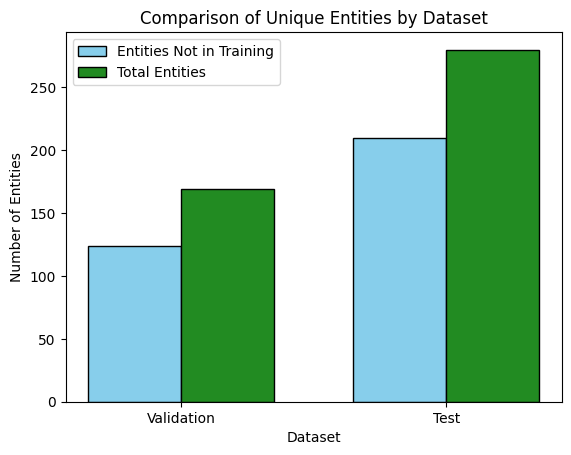

In [ ]:
import matplotlib.pyplot as plt

labels = list(unique_counts.keys())

# Set the width of the bars
bar_width = 0.35

# Set the positions for the bars
x = np.arange(len(labels))

# Plot the bars for unique_counts
plt.bar(x - bar_width/2, unique_counts.values(), bar_width, label='Entities Not in Training', color='skyblue', edgecolor='black')

# Plot the bars for counts
plt.bar(x + bar_width/2, counts.values(), bar_width, label='Total Entities', color='forestgreen', edgecolor='black')

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Number of Entities')
plt.title('Comparison of Unique Entities by Dataset')
plt.xticks(x, labels)

# Add legend
plt.legend()
plt.savefig('comparison_plot.png')